# General Note
In order to guide you through the homework, we put "...COMPLETE HERE..." as placeholder for you to complete the homework.

In [1]:
%matplotlib inline


# Classifying Names with a Character-Level RNN

We will biuld and train a character-level *Recurrent Neural
Network* (*RNN*) to classify words.

A character-level RNN reads words as a series of characters -
it outputs a prediction and hidden state at each step, and feeds the
previous hidden state into each next step. We take the final prediction
to be the output, that represents which class the word belongs to.

We want to predict the Language class to which belongs the Surnames.

## Preparing the Data

We will create a dictionary of lists of names per language,
``{language: [names ...]}``.


In [2]:
!git clone https://github.com/sarafrr/pytorch-tutorial-nlp-public.git

Cloning into 'pytorch-tutorial-nlp-public'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 100 (delta 39), reused 81 (delta 23), pack-reused 0
Receiving objects: 100% (100/100), 1.55 MiB | 12.00 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
# general import

import os
from glob import glob
from io import open
import string
import numpy as np
import random
import torch
import torch.nn as nn

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running application on {device}')

Running application on cpu


In [4]:
def getFiles(path):
  return glob(path)

file_list = getFiles('./data/Names/*.txt')
print(file_list[:2])

['./data/Names/Japanese.txt', './data/Names/Vietnamese.txt']


In [5]:
!rm -r pytorch-tutorial-nlp-public/

In [6]:
# read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

print(readLines(file_list[0]))
print(readLines(file_list[1]))

['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara', 'Aizawa', 'Ajibana', 'Akaike', 'Akamatsu', 'Akatsuka', 'Akechi', 'Akera', 'Akimoto', 'Akita', 'Akiyama', 'Akutagawa', 'Amagawa', 'Amaya', 'Amori', 'Anami', 'Ando', 'Anzai', 'Aoki', 'Arai', 'Arakawa', 'Araki', 'Arakida', 'Arato', 'Arihyoshi', 'Arishima', 'Arita', 'Ariwa', 'Ariwara', 'Asahara', 'Asahi', 'Asai', 'Asano', 'Asanuma', 'Asari', 'Ashia', 'Ashida', 'Ashikaga', 'Asuhara', 'Atshushi', 'Ayabito', 'Ayugai', 'Baba', 'Baisotei', 'Bando', 'Bunya', 'Chiba', 'Chikamatsu', 'Chikanatsu', 'Chino', 'Chishu', 'Choshi', 'Daishi', 'Dan', 'Date', 'Dazai', 'Deguchi', 'Deushi', 'Doi', 'Ebina', 'Ebisawa', 'Eda', 'Egami', 'Eguchi', 'Ekiguchi', 'Endo', 'Endoso', 'Enoki', 'Enomoto', 'Erizawa', 'Eto', 'Etsuko', 'Ezakiya', 'Fuchida', 'Fugunaga', 'Fujikage', 'Fujimaki', 'Fujimoto', 'Fujioka', 'Fujishima', 'Fujita', 'Fujiwara', 'Fukao', 'Fukayama', 'Fukuda', 'Fukumitsu', 'Fukunaka', 'Fukuoka', 'Fukusaku', 'Fukushima', 'Fukuyama', 'Fukuzawa', 'Fumihiko', 'Fun

In [7]:
# category_words is a dict with the key as the language
# and the value a list with all the possible names in the specific language
category_words = {}
all_categories = []
alphabet = set()

for filename in file_list:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    for word in lines:
      alphabet |= set(word)
    category_words[category] = lines

# letter to index
l_to_i = dict(zip(alphabet, range(len(alphabet))))
print(category_words)
n_categories = len(all_categories)
print(f'N. of languages: {n_categories}')
print(l_to_i)
n_letters = len(l_to_i)
print(f'The alphabet has {n_letters} letters')

{'Japanese': ['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara', 'Aizawa', 'Ajibana', 'Akaike', 'Akamatsu', 'Akatsuka', 'Akechi', 'Akera', 'Akimoto', 'Akita', 'Akiyama', 'Akutagawa', 'Amagawa', 'Amaya', 'Amori', 'Anami', 'Ando', 'Anzai', 'Aoki', 'Arai', 'Arakawa', 'Araki', 'Arakida', 'Arato', 'Arihyoshi', 'Arishima', 'Arita', 'Ariwa', 'Ariwara', 'Asahara', 'Asahi', 'Asai', 'Asano', 'Asanuma', 'Asari', 'Ashia', 'Ashida', 'Ashikaga', 'Asuhara', 'Atshushi', 'Ayabito', 'Ayugai', 'Baba', 'Baisotei', 'Bando', 'Bunya', 'Chiba', 'Chikamatsu', 'Chikanatsu', 'Chino', 'Chishu', 'Choshi', 'Daishi', 'Dan', 'Date', 'Dazai', 'Deguchi', 'Deushi', 'Doi', 'Ebina', 'Ebisawa', 'Eda', 'Egami', 'Eguchi', 'Ekiguchi', 'Endo', 'Endoso', 'Enoki', 'Enomoto', 'Erizawa', 'Eto', 'Etsuko', 'Ezakiya', 'Fuchida', 'Fugunaga', 'Fujikage', 'Fujimaki', 'Fujimoto', 'Fujioka', 'Fujishima', 'Fujita', 'Fujiwara', 'Fukao', 'Fukayama', 'Fukuda', 'Fukumitsu', 'Fukunaka', 'Fukuoka', 'Fukusaku', 'Fukushima', 'Fukuyama', 'Fukuzawa', 'Fu

In [8]:
# this is all the necessary code to set the seed
def set_seed(seed : int = 123):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [9]:
set_seed()

### Turning Names into Tensors

As always, we have to convert textual data into tensors.

To represent a single letter, we use a "one-hot vector" of size
``(1 x n_letters)``, where 1 is the respective index of the letter it is representing.

To make a word we combine a bunch of those representations into a 2D matrix
``(word_length x 1 x n_letters)``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here, for the sake of simplicity.




# Question 1
Create the auxiliary function to process the data to have the input suitable for `nn.Embedding`. This is because one of the following questions will be to try not to use one-hot-encoding representation, but use the embedding layer instead.

In [10]:
def letterToIndex(letter):
  '''
  Returns the index of a letter in the alphabet
  '''
  return l_to_i[letter]

def wordToOneHotTensor(word):
  '''
  Returns the word in zero-hot encoding
  '''
  tensor = torch.zeros(len(word), 1, n_letters).long()
  for idx, let in enumerate(word):
      tensor[idx][0][letterToIndex(let)] = 1
  return tensor

def wordToEmbedding(word):
  indexes = [letterToIndex(letter) for letter in word]
  return torch.tensor(indexes, dtype=torch.long)

tmp = 'Aarle'

print(f'N. of letters {len(alphabet)}')
print(f'Length of the word {len(tmp)}\n')
print(wordToOneHotTensor(tmp).size())
print(wordToOneHotTensor(tmp))
print('\n')
print(wordToEmbedding(tmp).size())
print(wordToEmbedding(tmp))

N. of letters 87
Length of the word 5

torch.Size([5, 1, 87])
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0

# Question 2
Implement the Vanilla RNN considering a batch size of dimension 1 (the simplest case).

## Creating the Network

Here, we are going to create RNNs with one only layer for the sake of simplicity. However, these models can be easily expanded to the more general case of having more layers.  

The Vanilla RNN is just 2 linear layers which operate on an input and hidden state.




In [11]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size).to(device)

In [12]:
class RNNEmb(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNNEmb, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.embedding = nn.Embedding(input_size, hidden_size)

    self.e2h = nn.Linear(hidden_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    embedded = self.embedding(input)
    combined = torch.cat((torch.unsqueeze(embedded, 0), hidden), 1)
    hidden = self.e2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size).to(device)

# Question 3
Implement an LSTM cell considering a batch size of dimension 1 (the simplest case).

In [13]:
class LSTM(torch.nn.Module):

    def __init__(self, input_length, hidden_length, output_length, type_layer):
        super(LSTM, self).__init__()

        self.input_length = input_length
        self.hidden_length = hidden_length
        self.output_length = output_length
        self.type_layer = type_layer

        # forget gate components
        self.linear_forget_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.linear_input_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.linear_input_w2 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_input = nn.Sigmoid()
        self.tanh_input = nn.Tanh()

        # out gate components
        self.linear_output_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_out = nn.Sigmoid()

        # final compnents
        self.linear_output_final = nn.Linear(self.hidden_length, self.output_length, bias=True)
        self.activation_final = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forget(self, x, h):
        # forget gate
        ret = self.linear_forget_w1(torch.cat((x, h), dim=1))
        return self.sigmoid_forget(ret)


    def input_gate(self, x, h):
        # input gate
        i_t = self.linear_input_w1(torch.cat((x, h), dim=1))
        C_t = self.linear_input_w2(torch.cat((x, h), dim=1))
        return self.sigmoid_input(i_t), self.tanh_input(C_t)


    def out_gate(self, x, h):
        ret = self.linear_output_w1(torch.cat((x, h), dim=1))
        return self.sigmoid_out(ret)


    def forward(self, x, tuple_in):
        x = x.to(torch.float32)
        (h, c_prev) = tuple_in

        # forget gate
        f_t = self.forget(x, h)

        # input gate
        i_t, c_t = self.input_gate(x, h)

        # updating the cell memory
        c_next = (c_prev * f_t) + (i_t * c_t)

        # calculate the main output gate
        o = self.out_gate(x, h)

        # produce next hidden output
        h_next = o * self.activation_final(c_next)

        return self.log_softmax(self.linear_output_final(h_next)), (h_next, c_next)


    def initHidden(self):
        return (torch.zeros(1, self.hidden_length).to(torch.float32).to(device), torch.zeros(1, self.hidden_length).to(torch.float32).to(device))

## Training
Preparing for Training
----------------------

The output of the network is a likelihood of each category. Use ``Tensor.topk`` to get the index
of the greatest value:




In [14]:
def categoryFromOutput(output):
    top_val, top_idx = output.topk(1)
    category_idx = top_idx[0].item()
    return all_categories[category_idx], category_idx

We will also want a quick way to get a training example (a name and its
language):




In [15]:
print(all_categories)

['Japanese', 'Vietnamese', 'Greek', 'Spanish', 'Portuguese', 'Russian', 'Dutch', 'Irish', 'Scottish', 'Czech', 'German', 'Polish', 'French', 'Arabic', 'Chinese', 'Korean', 'Italian', 'English']


# Related to Question 1
In order to use the embeddings in place of one-hot-encoded representation, you should modify also the function `randomChoice()` in the following snippet of code to have the correct input data.

In [16]:
import random

def randomChoice(l):
  '''
  Returns a random integer given the list of languages
  '''
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(model):
    category = randomChoice(all_categories)
    word = randomChoice(category_words[category])
    # create a long tensor with the index of the language
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    if model == 'linear': word_tensor = wordToOneHotTensor(word)
    else: word_tensor = wordToEmbedding(word)

    return category, word, category_tensor, word_tensor

for ty in ['embeds', 'linear']:
  for i in range(4):
    category, word, category_tensor, word_tensor = randomTrainingExample(ty)
    print('category =', category, '\n word =', word, '\n category_tensor =', category_tensor, '\n word_tensor =', word_tensor, '\n len word_tensor =', word_tensor.size())
    print('\n')

category = Vietnamese 
 word = Kieu 
 category_tensor = tensor([1]) 
 word_tensor = tensor([20, 40,  9,  6]) 
 len word_tensor = torch.Size([4])


category = Greek 
 word = Vassilikos 
 category_tensor = tensor([2]) 
 word_tensor = tensor([60, 67, 10, 10, 40, 37, 40, 13,  8, 10]) 
 len word_tensor = torch.Size([10])


category = Arabic 
 word = Naser 
 category_tensor = tensor([13]) 
 word_tensor = tensor([71, 67, 10,  9, 39]) 
 len word_tensor = torch.Size([5])


category = Spanish 
 word = Álvarez 
 category_tensor = tensor([3]) 
 word_tensor = tensor([68, 37, 53, 67, 39,  9, 14]) 
 len word_tensor = torch.Size([7])


category = French 
 word = Vipond 
 category_tensor = tensor([12]) 
 word_tensor = tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Training the Network
 In the following change the initialisation with the model you want to use.




In [17]:
n_hidden = 128
criterion = nn.NLLLoss()

In [18]:
rnn = RNN(n_letters, n_hidden, n_categories, 'linear').to(device)
next(rnn.parameters()).device

device(type='cpu')

In [19]:
rnn_embeds = RNNEmb(n_letters, n_hidden, n_categories, 'embeds').to(device)
next(rnn_embeds.parameters()).device

device(type='cpu')

In [20]:
lstm = LSTM(n_letters, n_hidden, n_categories, 'linear').to(device)
next(lstm.parameters()).device

device(type='cpu')

Each loop of training will:

1. Create input and target tensors
2. Read each letter in and keep the hidden state for next letter
3. Compare final output to target
4. Back-propagate
5. Return the output and loss




# Question 3.1
After having tryied the learning rate which is proposed in the script, `0.005`, use the learning rate equal to `1`. What is happening? Can you explaing why?

## Answer
It is happening that the loss goes to NAN values, indeed the problem that we are experiencing in this case is the so called **exploding gradient problem**. Th epoint is that the RNN backbone has the drawback that the closer I move to the end of the sequence of inputs the more I have to add and to multiply the weights of my network. So during the training the graduient might *vanishing* or *exploding* like in this case, so it means that I will not learn lonmg term dependencies.

\begin{equation}
A_t = \Theta_cA_{t-1} + \Theta_xx_t
\end{equation}

Let's consider the recurrence on the hidden space and forget the input
\begin{equation}
 A_t = \Theta_cA_{t-1}
\end{equation}

\begin{equation}
\begin{aligned}
A_1 &= \Theta_cA_0\\
A_2 &= \Theta_cA_1 = \Theta_c(\Theta_cA_0) = \Theta_c^2A_0\\
A_3 &= \Theta_cA_2 = \Theta_c(\Theta_cA_1) = \Theta_c(\Theta_c(\Theta_cA_0)) = \Theta_c^3A_0\\
...\\
A_t &= \Theta_c^tA_0 \quad \text{the parameters are muiltiplied t times}
\end{aligned}
\end{equation}




# Question 3.2
What is the quickest way to get rid of the problem? Modify the code trying to implement a possible solution.
## Answer
The quickest way to get rid of the problem is to modify the code inserting the **gradient clipping**.

Let's $g = \frac{\partial\mathcal{L}}{\partial \Theta_c}$ are the gradeitns of the loss $\mathcal{L}$ with respect to the model's parameters $\Theta_c$

If $||g|| \leq c$ then $g = c \cdot \frac{g}{||g||}$, this ensure that I have no longer strong weights since I make the norm of $g$ maximum of $c$ . Indeed this helps the gradient descent to have a resonabe behaviour even if the loss landscape of the model is irregular.

# Question 3.2
What is the other problem this kind of network has? And what are the possible solutions?
## Answer
The architecture have multiple drowbacks but the main two are the following one:
1. **Limited Contextual Information**: RNNs have a limited ability to capture long-range dependencies in sequences. This is because they suffer from the vanishing gradient problem, which hampers their ability to retain information over many time steps.
2. **Difficulty Learning Long-Term Dependencies**: RNNs find it challenging to learn dependencies that are separated by a large number of time steps. This limits their ability to capture long-term dependencies in sequences. For example given a sequence of words the information of the first word that is kept at the last input is very insignificant respect to the last input word.

One of the possible soluton is to is to switch to an LSTM architecture. The LSTM has the following main advantages respect to a classical RNN:
1. **Gating Structure**: LSTMs incorporate a gating mechanism that consists of input, forget, and output gates. These gates control the information flow, allowing the network to decide what information to keep or forget at each time step.
2. **Long-Term Dependency Handling**: LSTMs are designed to address the vanishing gradient problem, allowing them to capture long-term dependencies. This is achieved through the use of a gating mechanism that regulates the flow of information through the cell state whoch as the main goal to retain the long term memory.
3. **Reduced Vanishing Gradient**: The architecture of LSTMs reduces the vanishing gradient problem, making possible tocapture long term dependencies through the all input sequence.

In [21]:
from torch import optim


def train(category_tensor, word_tensor, model, optimizer):

    h = model.initHidden()

    optimizer.zero_grad()
    # iterate over the word for all the letters in the word
    for i in range(word_tensor.size(0)):

      output, h = model(word_tensor[i], h)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Gradient clipping using that clips the gradients using a vector norm
    # Clips gradient norm of an iterable of parameters.
    #The norm is computed over all gradients together, as if they were concatenated into a single vector. Gradients are modified in-place.
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)

    # Basic Gradient Clipping
    torch.nn.utils.clip_grad_value_(model.parameters(), 1.)

    optimizer.step()
    return output, loss.item()

The ``train`` function returns the output and loss we can print what are its predictions and also to keep track of the loss.
We can choose how many examples print these outputs thanks to ``print_every``.




In [22]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

def run_training(model, optimizer):
  n_iters = 100000
  print_every = 5000
  plot_every = 1000

  # keep track of losses for plotting
  current_loss = 0
  all_losses = []


  start = time.time()

  for iter in range(1, n_iters + 1):
      category, word, category_tensor, word_tensor = randomTrainingExample(model.type_layer)

      category_tensor = category_tensor.to(device)
      word_tensor = word_tensor.to(device)

      output, loss = train(category_tensor, word_tensor, model, optimizer)
      current_loss += loss

      if iter % print_every == 0:
          category_pred, category_idx = categoryFromOutput(output)
          correct = 'OK' if category_pred == category else 'NO (%s)' % category
          print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, word, category_pred, correct))

      # add the current loss to the list of losses
      if iter % plot_every == 0:
          all_losses.append(current_loss / plot_every)
          current_loss = 0

  return all_losses

In [23]:
optimizer_rnn = optim.SGD(rnn.parameters(), lr = 0.005)

rnn_losses = run_training(rnn, optimizer_rnn)

5000 5% (0m 10s) 2.8274 Readman / Irish NO (English)
10000 10% (0m 20s) 0.6834 Rapallino / Italian OK
15000 15% (0m 30s) 1.3942 Gardinier / French OK
20000 20% (0m 39s) 0.7761 Kouros / Greek OK
25000 25% (0m 49s) 0.6349 Kui / Chinese OK
30000 30% (0m 59s) 1.3447 Findley / English OK
35000 35% (1m 8s) 0.1295 Benivieni / Italian OK
40000 40% (1m 19s) 1.2276 Cao / Chinese OK
45000 45% (1m 29s) 0.5175 Awad / Arabic OK
50000 50% (1m 38s) 3.8910 Kim / Korean NO (Vietnamese)
55000 55% (1m 48s) 0.0265 Martynov / Russian OK
60000 60% (1m 59s) 2.9630 Agayan / Irish NO (Russian)
65000 65% (2m 7s) 2.3470 Wraight / Irish NO (English)
70000 70% (2m 18s) 3.5792 Laar / Scottish NO (Dutch)
75000 75% (2m 28s) 0.4297 Chou / Korean OK
80000 80% (2m 37s) 0.6230 Sun / Korean OK
85000 85% (2m 48s) 1.3393 Laurenz / Spanish NO (German)
90000 90% (2m 58s) 1.9717 Charron / Irish NO (French)
95000 95% (3m 7s) 1.2394 Kelly / Irish NO (Scottish)
100000 100% (3m 17s) 3.9135 Sarkozy / Russian NO (French)


In [24]:
optimizer_rnn_embeds = optim.SGD(rnn_embeds.parameters(), lr = 0.005)

rnn_embeds_losses = run_training(rnn_embeds, optimizer_rnn_embeds)

5000 5% (0m 12s) 3.8508 Widerlechner / German NO (Czech)
10000 10% (0m 23s) 1.5926 Messana / Spanish NO (Italian)
15000 15% (0m 35s) 0.2211 Duong / Vietnamese OK
20000 20% (0m 46s) 4.2958 Dolejsi / Italian NO (Czech)
25000 25% (0m 59s) 4.1992 Eikhenbaum / Vietnamese NO (Russian)
30000 30% (1m 11s) 1.5479 Vennen / Irish NO (Dutch)
35000 35% (1m 23s) 6.0758 Landau / Greek NO (German)
40000 40% (1m 34s) 0.5433 Rao / Chinese OK
45000 45% (1m 46s) 0.8286 Nolan / Irish OK
50000 50% (1m 58s) 0.7051 Dubhan / Irish OK
55000 55% (2m 10s) 1.4972 Savatier / French OK
60000 60% (2m 22s) 2.3832 Pudel / Spanish NO (Czech)
65000 65% (2m 33s) 1.2856 Cormac / Irish OK
70000 70% (2m 45s) 0.2552 Serafim / Portuguese OK
75000 75% (2m 57s) 2.3127 Fashingbauer / French NO (German)
80000 80% (3m 9s) 0.3140 Davidson / Scottish OK
85000 85% (3m 25s) 2.2715 Han / Chinese NO (Korean)
90000 90% (3m 39s) 5.1062 Vargas / Greek NO (Portuguese)
95000 95% (3m 51s) 1.9823 Sechnall / English NO (Irish)
100000 100% (4m 4s

In [25]:
optimizer_lstm = optim.Adam(lstm.parameters(), lr = 0.001)

lstm_losses = run_training(lstm, optimizer_lstm)

5000 5% (0m 45s) 1.4948 Youn / Chinese NO (Korean)
10000 10% (1m 28s) 4.9676 Ents / Dutch NO (Russian)
15000 15% (2m 11s) 0.7360 Chiba / Japanese OK
20000 20% (2m 53s) 0.3148 Qiu / Chinese OK
25000 25% (3m 35s) 1.7035 Jez / Chinese NO (Polish)
30000 30% (4m 16s) 0.7276 Hlgatyan / Russian OK
35000 35% (4m 58s) 3.6285 Jagoda / Japanese NO (Polish)
40000 40% (5m 41s) 0.9613 Alfaro / Spanish OK
45000 45% (6m 23s) 0.0661 Banos / Greek OK
50000 50% (7m 8s) 0.3301 Korycansky / Czech OK
55000 55% (7m 50s) 0.0016 Higuchi / Japanese OK
60000 60% (8m 33s) 0.2975 Robledo / Spanish OK
65000 65% (9m 15s) 0.0000 Kotsiopoulos / Greek OK
70000 70% (10m 0s) 0.0127 Krüger / German OK
75000 75% (10m 54s) 0.0068 Velazquez / Spanish OK
80000 80% (11m 36s) 0.0345 Alves / Portuguese OK
85000 85% (12m 19s) 0.0821 Cabral / Portuguese OK
90000 90% (13m 2s) 0.0286 Jin / Chinese OK
95000 95% (13m 44s) 0.5775 Dornan / English OK
100000 100% (14m 26s) 0.0095 Budny / Polish OK


# Question 4
Use the LSTM to make the predictions, feel free to modify the optimizer and/or the learning rate to see the training loss decreasing. Pay attention that the LSTM returns a number of components different by the ones that are returned by a Vanilla RNN, thus modify the code accordingly (especially the `train()` function).


# Question 5
Modify the network of the Vanilla RNN to use an embedding layer and not using the one-hot-encoding representation and train again the network. Verify that the network has been trained considering the training loss. It has to be decreasing.

### See that the training loss is decreasing

Plotting the historical loss from ``all_losses`` shows the network
learning:




In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def print_losses(all_losses, title):
  plt.figure()
  plt.plot(all_losses)
  plt.xlabel('Iterations')
  plt.ylabel('NLLLoss')
  plt.title(title)
  plt.show()

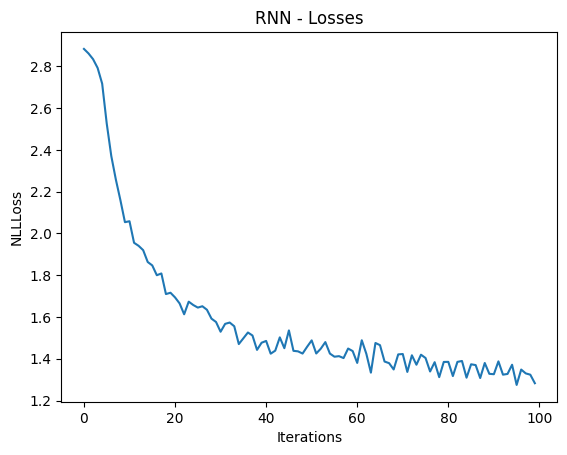

In [27]:
print_losses(rnn_losses, 'RNN - Losses')

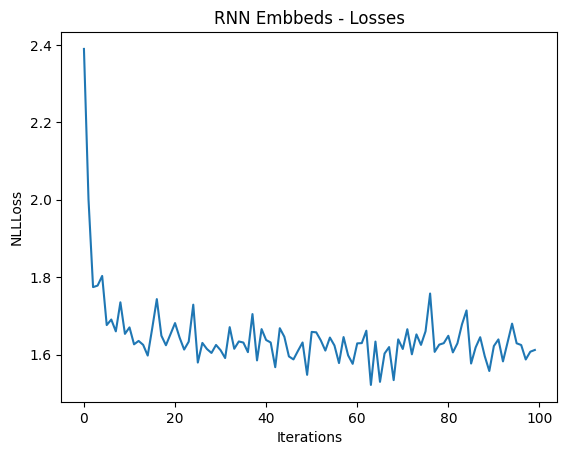

In [28]:
print_losses(rnn_embeds_losses, 'RNN Embbeds - Losses')

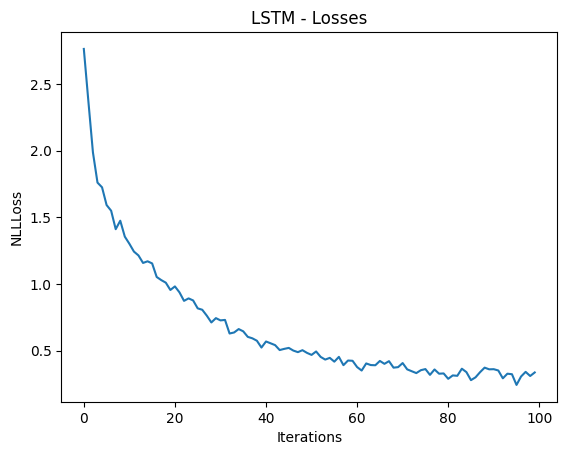

In [29]:
print_losses(lstm_losses, 'LSTM - Losses')

In [30]:
# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    line_tensor = line_tensor.to(device)

    hidden = model.initHidden()

    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output, hidden = model(line_tensor[i], hidden)

    return output

def create_confusion_matrix(model):
  # Keep track of correct guesses in a confusion matrix
  confusion = torch.zeros(n_categories, n_categories)
  n_confusion = 10000

  # Go through a bunch of examples and record which are correctly guessed
  for i in range(n_confusion):
      category, _, _, line_tensor = randomTrainingExample(model.type_layer)
      output = evaluate(line_tensor, model)
      guess, guess_i = categoryFromOutput(output)
      category_i = all_categories.index(category)
      confusion[category_i][guess_i] += 1

  # Normalize by dividing every row by its sum
  for i in range(n_categories):
      confusion[i] = confusion[i] / confusion[i].sum()

  # Set up plot
  fig, ax = plt.subplots(figsize=(20, 20))
  cax = ax.matshow(confusion)

  # Display values inside the cells
  for i in range(len(all_categories)):
      for j in range(len(all_categories)):
          ax.text(j, i, str(round(confusion[i, j].item(), 3)), va='center', ha='center', color='white')

  fig.colorbar(cax, shrink=0.8)

  # Set up axes
  ax.set_xticklabels([''] + all_categories, rotation=45)
  ax.set_yticklabels([''] + all_categories)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.xaxis.set_label_coords(0.5, -0.1)
  ax.xaxis.tick_bottom()
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.set_ticks_position("none")

  plt.title(f'Confusion Matrix of {model.__class__.__name__}')
  plt.show()

<ipython-input-30-7dd2fcf2a072>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-30-7dd2fcf2a072>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


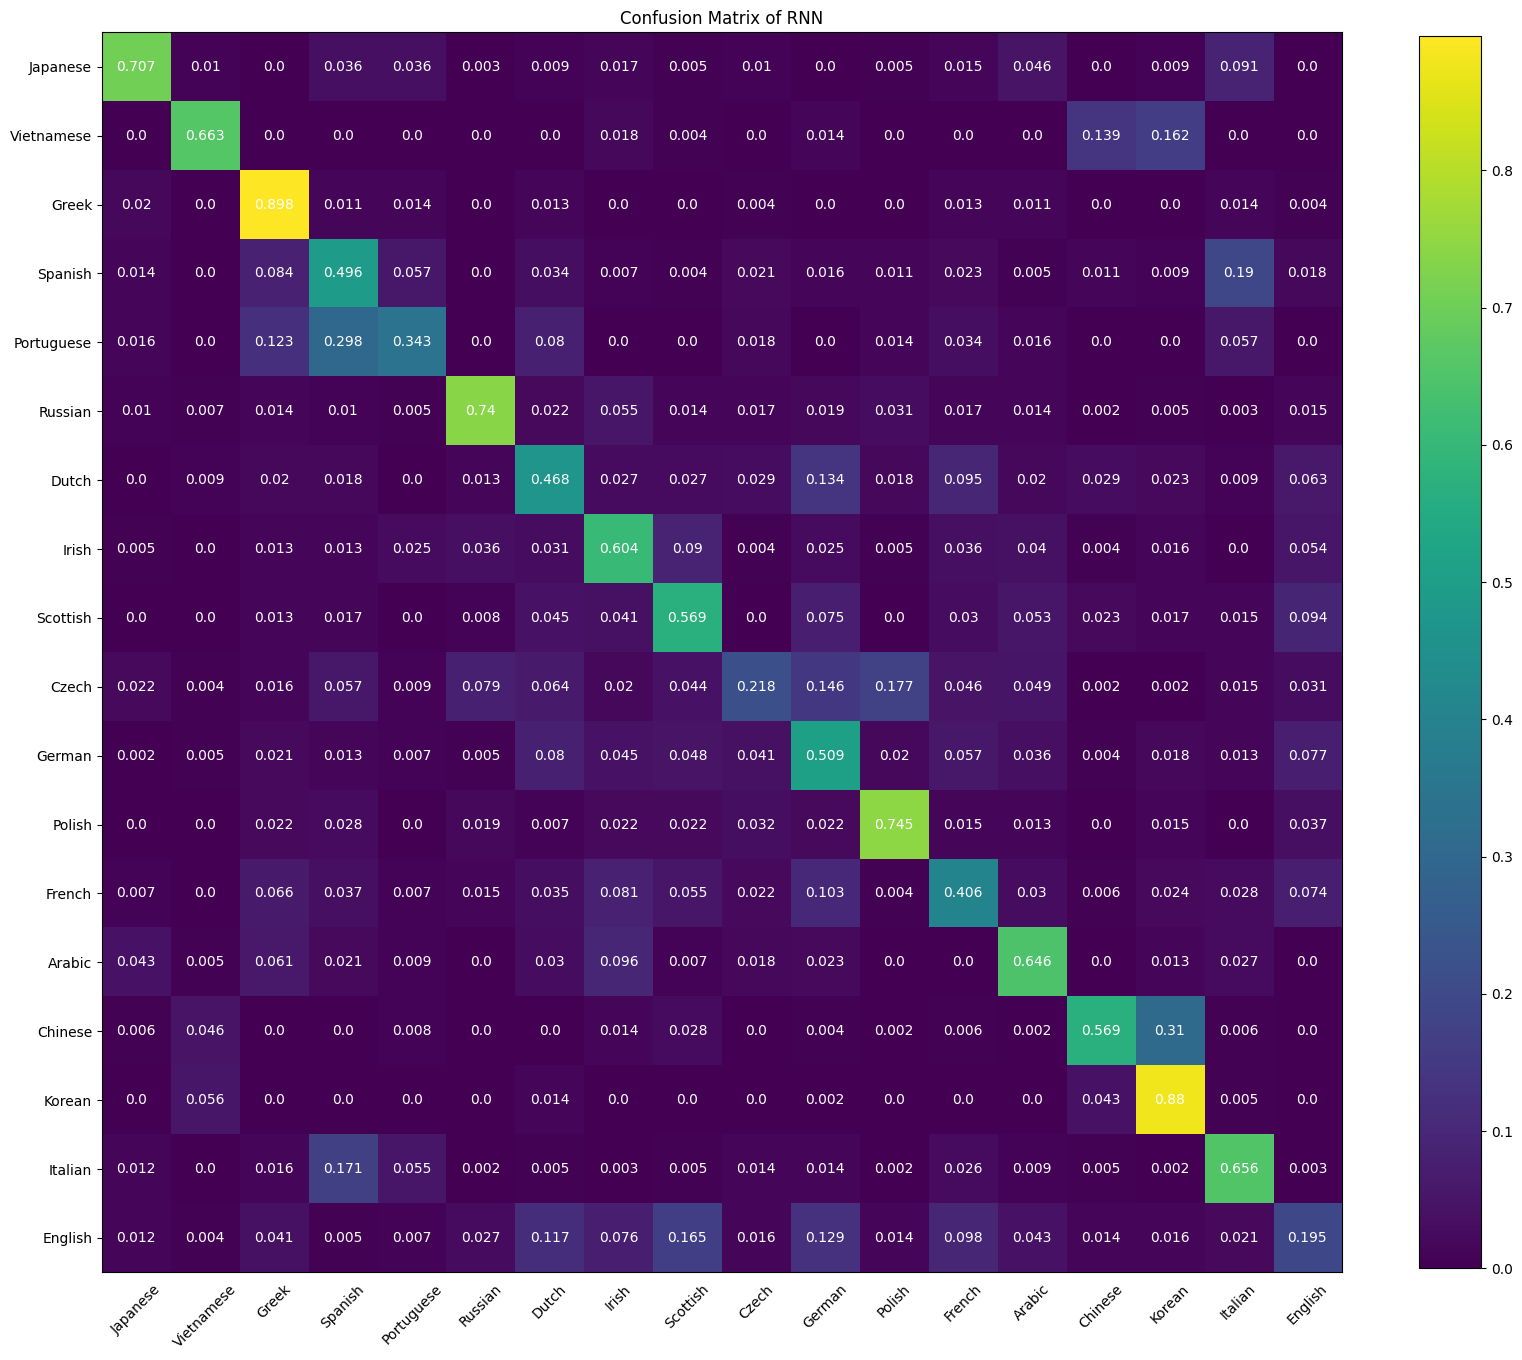

In [31]:
create_confusion_matrix(rnn)

<ipython-input-30-7dd2fcf2a072>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-30-7dd2fcf2a072>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


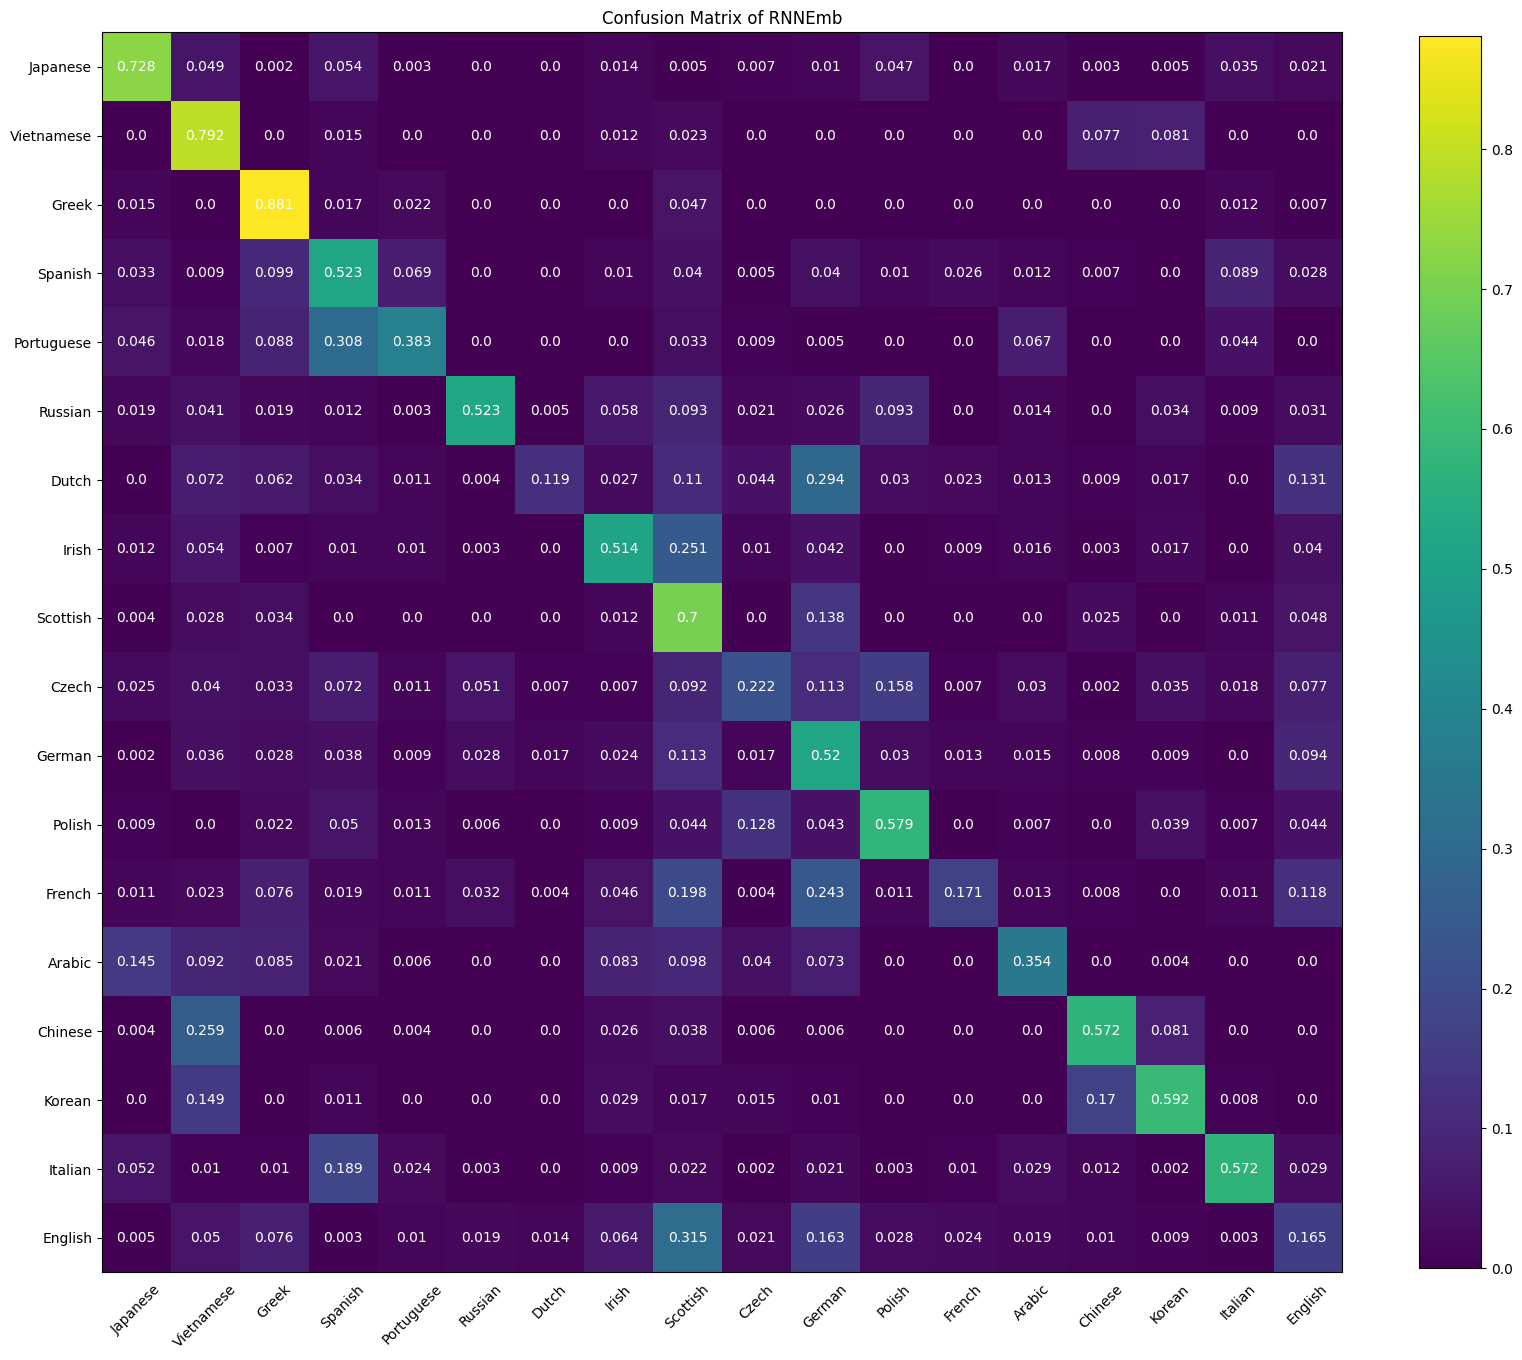

In [32]:
create_confusion_matrix(rnn_embeds)

<ipython-input-30-7dd2fcf2a072>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-30-7dd2fcf2a072>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


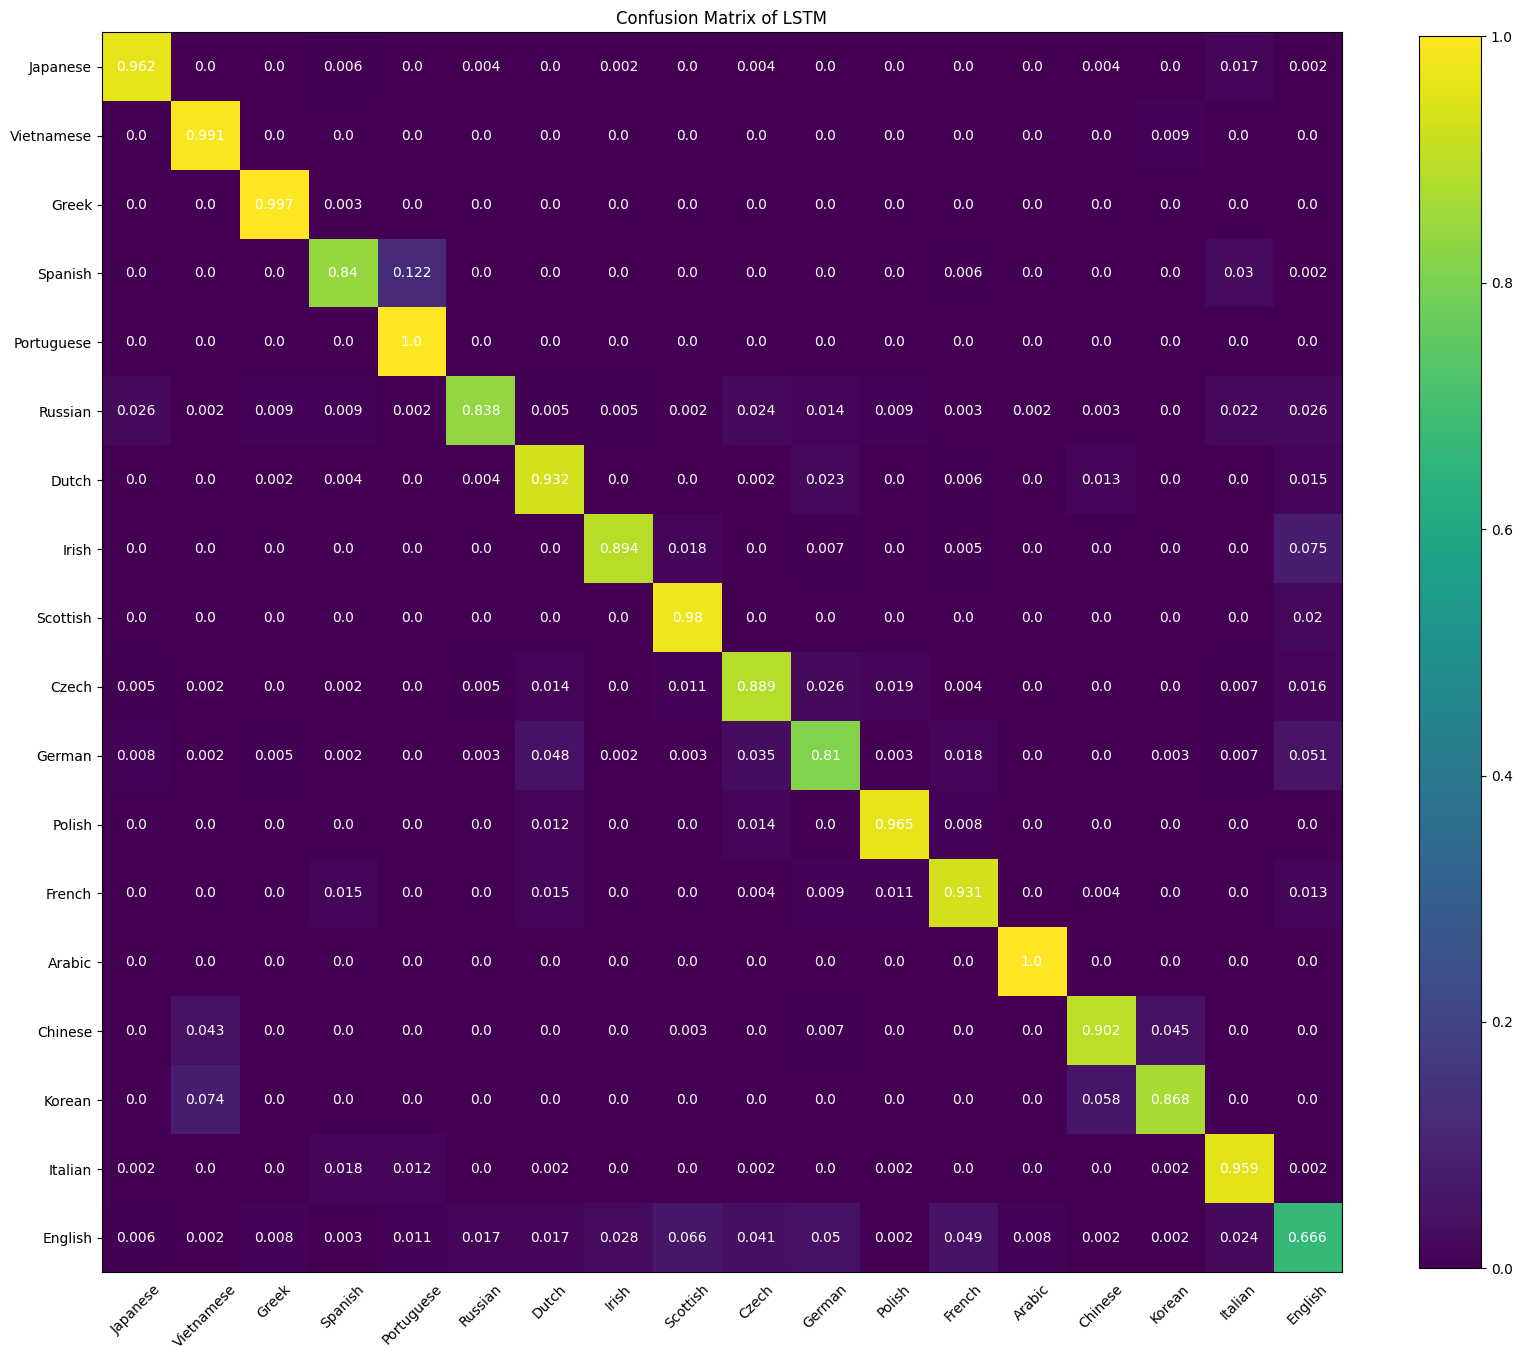

In [33]:
create_confusion_matrix(lstm)

# Question 6
Make a function to extract the embedding and visualise in the 2D space with the color w.r.t. the Language class. Feel free to modify the `get_embeddings()` function to return what you think could be useful for the plotting. Let's use also the cosine similarity between the embeddings to see if the embedding has a sense.

In [34]:
def getTrainingSample(word, model):
    # create a long tensor with the index of the language
    if model.type_layer == 'linear': return wordToOneHotTensor(word)
    else: return wordToEmbedding(word)

In [35]:
def get_lists_and_dict(category_words):

  sournames, languages_sournames = [], []
  category_words_new = {}

  id = 0
  for lang, list_sournames in category_words.items():
    category_words_new[lang] = []
    for sourname in list_sournames:
      category_words_new[lang].append((id, sourname))
      sournames.append(sourname)
      languages_sournames.append(lang)
      id += 1

  return sournames, languages_sournames, category_words_new

# category_words_new -> dictionary similar to category_words with the additiona id in each sourname
# sournames -> list of sournames derived from the dictionary keys
# languages_sournames -> list of languages derived from the dictionary values

sournames, languages_sournames, category_words_new = get_lists_and_dict(category_words)

In [42]:
def get_embeddings(model):

  embeddings = np.empty((0,128))
  #embeddings = np.empty((0, 256)) if model.__class__.__name__ == 'LSTM' else np.empty((0,128))

  model.eval()  # Set the model in evaluation mode

  # Extract hidden states from your dataset
  # Assuming you have a dataset of sequences, you can iterate over them and collect the hidden states

  # Iterate over your dataset and extract hidden states
  for sourname in sournames:
      hidden = model.initHidden()

      tensor_sourname = getTrainingSample(sourname, model).to(device)

      with torch.no_grad():
          for i in range(tensor_sourname.size(0)):
            _, hidden = model(tensor_sourname[i], hidden)


      if model.__class__.__name__ == 'LSTM':
          #hidden = torch.cat(hidden, dim=1).cpu().numpy()
          #embeddings = np.vstack((embeddings, hidden))
          embeddings = np.vstack((embeddings, hidden[0].cpu().numpy()))
      else:
          embeddings = np.vstack((embeddings, hidden.cpu().numpy()))

  return embeddings

In [43]:
def get_tsne_embeds(embeds, indices):
  embeds_tsne_indices = TSNE().fit_transform(embeds.squeeze()[indices,:])
  embeds_tsne_all = TSNE().fit_transform(embeds.squeeze())
  return embeds_tsne_indices, embeds_tsne_all

In [50]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def print_embeddings(embeds_tsne_indices, indices, title):
    colors = ['darkblue', 'orange', 'green', 'mediumturquoise', 'darkmagenta', 'khaki', 'dimgray', 'royalblue', 'darkslategray', 'coral', 'mediumorchid', 'saddlebrown', 'lightpink', 'mediumseagreen', 'olivedrab', 'slategray', 'mediumvioletred', 'darkgoldenrod']

    fig, ax = plt.subplots(figsize=(12, 12))

    # Create an empty list to store unique legend entries
    legend_entries = []
    unique_languages = list(category_words.keys())

    for i, val in enumerate(indices):
        #color = colors[sournames.index(languages_sournames[val])]
        color = colors[unique_languages.index(languages_sournames[val])]

        # Check if the language is already in the legend_entries list
        if languages_sournames[val] not in legend_entries:
            # Add the language to legend_entries to avoid duplicates
            legend_entries.append(languages_sournames[val])
            plt.scatter(*embeds_tsne_indices[i, :], color=color, label=languages_sournames[val])
        else:
            # If the language is already in legend_entries, don't add a label
            plt.scatter(*embeds_tsne_indices[i, :], color=color)

    plt.title(title)

    # Display the legend with unique entries
    plt.legend()
    plt.show()

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

def get_embds_sim(embeddings):
  sim = cosine_similarity(embeddings)
  np.fill_diagonal(sim, -1.0)
  return sim

In [46]:
viz_words = 2000
indices = np.random.choice(len(sournames), viz_words)

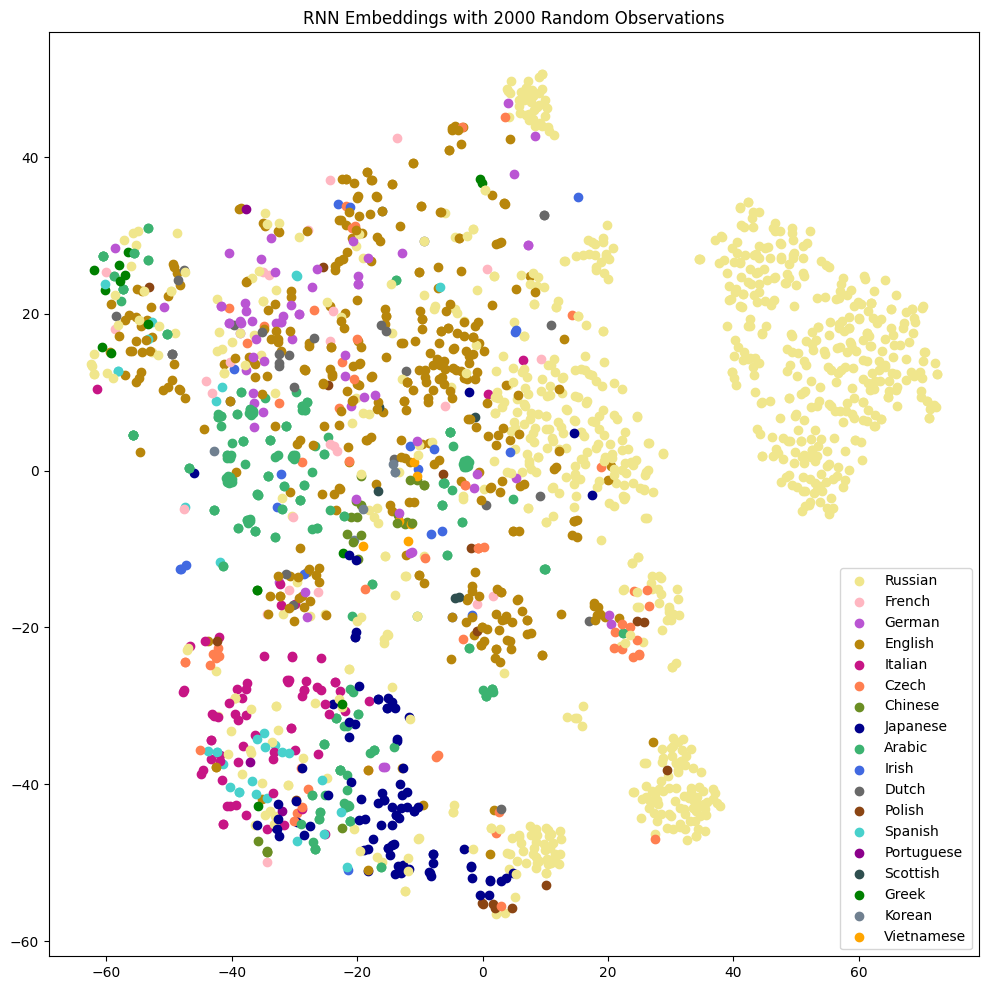

In [51]:
embeds_rnn = get_embeddings(rnn)
embeds_tsne_indices_rnn, embeds_tsne_all_rnn = get_tsne_embeds(embeds_rnn, indices)
print_embeddings(embeds_tsne_indices_rnn, indices, f'RNN Embeddings with {viz_words} Random Observations')
sim_rnn = get_embds_sim(embeds_rnn)

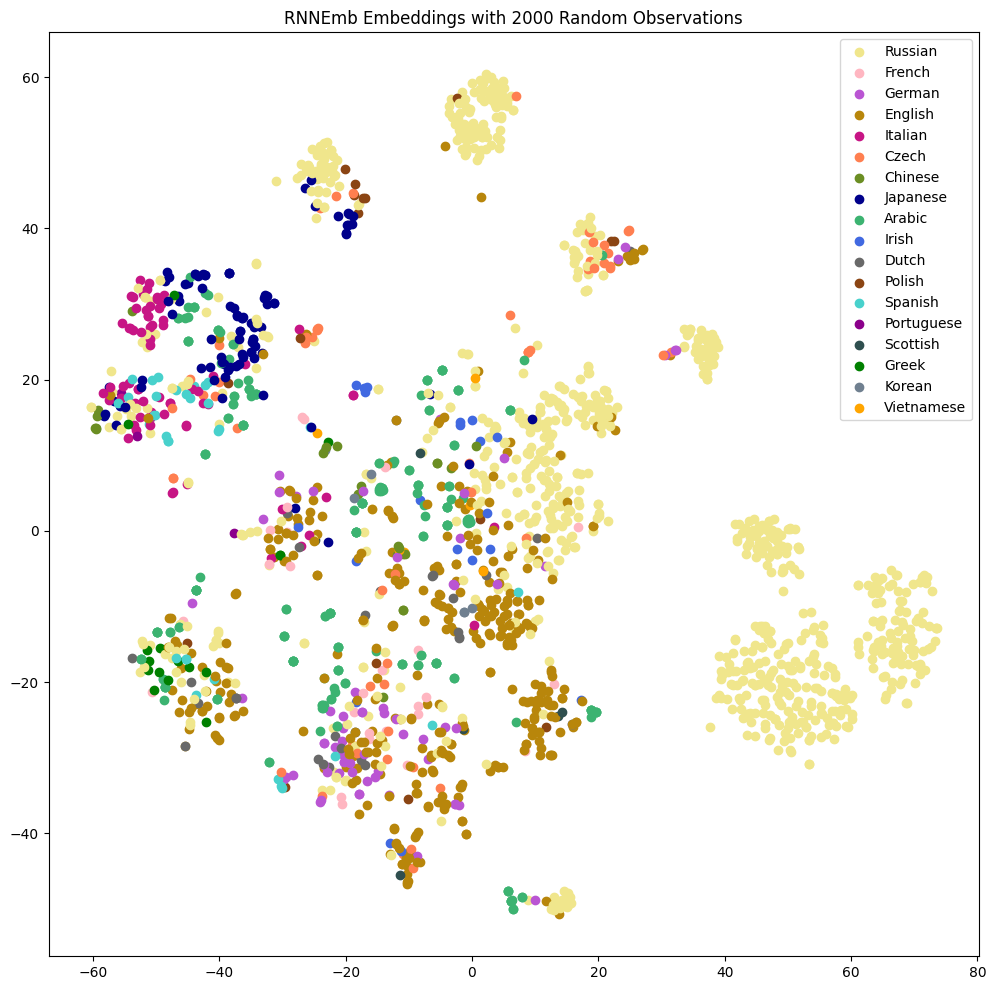

In [52]:
embeds_rnn_emb = get_embeddings(rnn_embeds)
embeds_tsne_indices_rnn_emb, embeds_tsne_all_rnn_emb = get_tsne_embeds(embeds_rnn_emb, indices)
print_embeddings(embeds_tsne_indices_rnn_emb, indices, f'RNNEmb Embeddings with {viz_words} Random Observations')
sim_rnn_emb = get_embds_sim(embeds_rnn_emb)

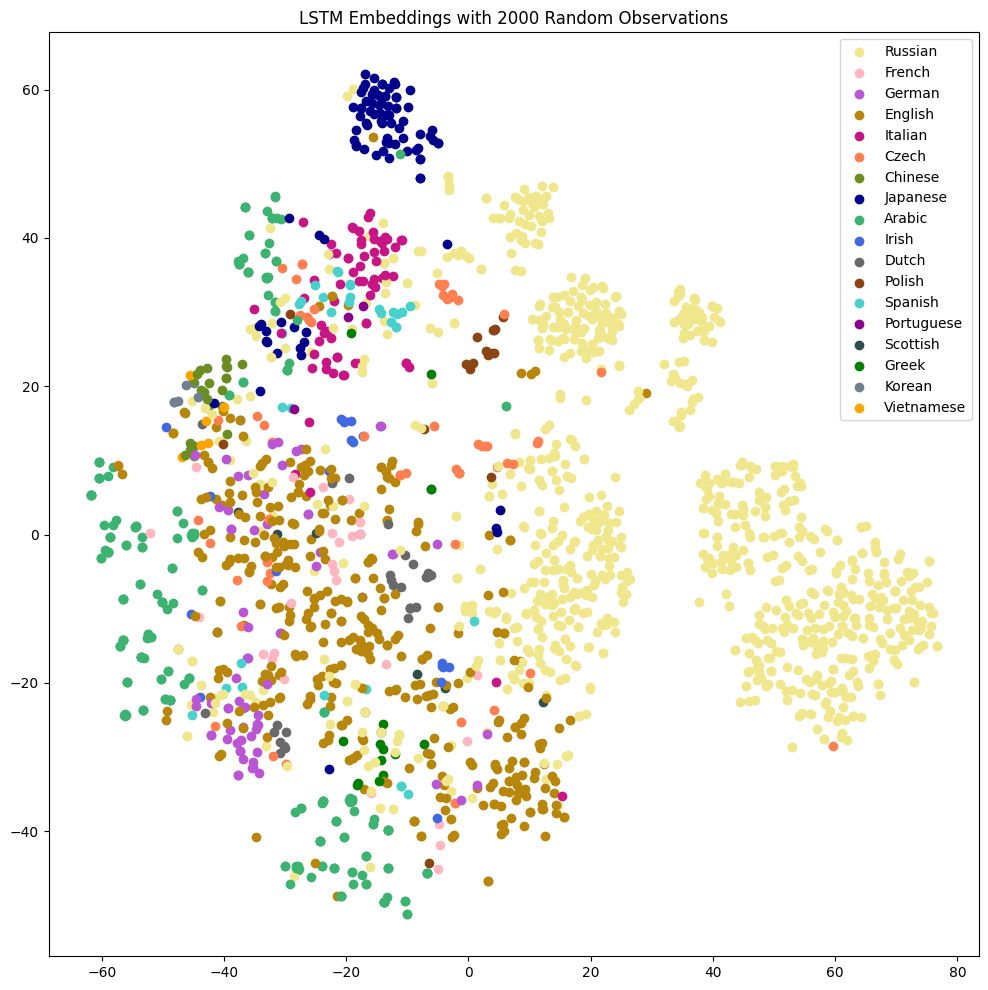

In [53]:
embeds_lstm = get_embeddings(lstm)
embeds_tsne_indices_lstm, embeds_tsne_all_lstm = get_tsne_embeds(embeds_lstm, indices)
print_embeddings(embeds_tsne_indices_lstm, indices, f'LSTM Embeddings with {viz_words} Random Observations')
sim_lstm = get_embds_sim(embeds_lstm)

In [54]:
def get_random_sournames_languages():
  list_idxs_lan_mat_sim = []
  for lang, sournames_list in category_words_new.items():

    id_rand_sourname, str_rand_sourname = random.sample(sournames_list, 1)[0]

    list_idxs_lan_mat_sim.append((id_rand_sourname, languages_sournames[id_rand_sourname]))

  return list_idxs_lan_mat_sim

list_idxs_lan_mat_sim = get_random_sournames_languages()

for id, lan in list_idxs_lan_mat_sim: print(f'{id} - {sournames[id]} - {lan}')

134 - Hatoyama - Japanese
1024 - Han - Vietnamese
1155 - Karkampasis - Greek
1391 - Guadarrama - Spanish
1615 - Paredes - Portuguese
4232 - Dzhuromsky - Russian
11326 - Sniders - Dutch
11450 - Maurice - Irish
11606 - Ferguson - Scottish
11777 - Geryk - Czech
12516 - Kerwer - German
12969 - Kosmatka - Polish
13114 - Coupe - French
15139 - Ganem - Arabic
15417 - Lew - Chinese
15626 - Hong - Korean
15883 - Benivieni - Italian
19802 - Veasey - English


In [55]:
def get_names_similarity(list_idxs_lan_mat_sim, embs_sim, top_k):

  dict_to_return = {}

  for values in list_idxs_lan_mat_sim:

    idx_in_mat_sim, lang = values

    most_sim_sournames_idx = np.flip(np.argsort(embs_sim[idx_in_mat_sim]))[:top_k]
    most_sim_sournames_str = [sournames[idx] for idx in most_sim_sournames_idx]
    most_sim_sournames_lan = [languages_sournames[idx] for idx in most_sim_sournames_idx]
    most_similar_sournames_sim = [embs_sim[idx_in_mat_sim, idx] for idx in most_sim_sournames_idx]

    dict_to_return[idx_in_mat_sim] = (lang, most_sim_sournames_idx)

    print(f'Most similar name for "{sournames[idx_in_mat_sim]} - ({lang})" are:\t{most_sim_sournames_str}')
    print(f'With corresponding languages:\t{most_sim_sournames_lan}')
    print(f'With corresponding indices:\t{most_sim_sournames_idx}')
    print(f'With corresponding Embedding Cosine Similarity of:\t{most_similar_sournames_sim}\n')

  return dict_to_return

In [56]:
# set the top-k names to see for a random name for each language
top_k = 30

In [57]:
dict_sim_rnn = get_names_similarity(list_idxs_lan_mat_sim, sim_rnn, top_k)

Most similar name for "Hatoyama - (Japanese)" are:	['Hatayama', 'Katayama', 'Fukuyama', 'Akiyama', 'Takayama', 'Nakayama', 'Muruyama', 'Fukayama', 'Ishiyama', 'Isayama', 'Kimiyama', 'Hatakeyama', 'Maruyama', 'Hirayama', 'Kajiyama', 'Sugiyama', 'Takahama', 'Munakata', 'Shiroyama', 'Yokoyama', 'Kawayama', 'Uchiyama', 'Yamagata', 'Toyama', 'Abukara', 'Tsukada', 'Koyama', 'Hatakeda', 'Umehara', 'Kakutama']
With corresponding languages:	['Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese']
With corresponding indices:	[133 308  94  14 815 563 530  87 248 236 352 132 443 163 279 788 803 520
 762 975 334 912 941 881   1 893 397 131 923 281]
With corresponding Embedding Cosine Similarity of:	[

In [58]:
dict_sim_rnn_emb = get_names_similarity(list_idxs_lan_mat_sim, sim_rnn_emb, top_k)

Most similar name for "Hatoyama - (Japanese)" are:	['Hatayama', 'Katayama', 'Sugiyama', 'Hirayama', 'Toyama', 'Takayama', 'Hiyama', 'Kajiyama', 'Ishiyama', 'Isayama', 'Kimiyama', 'Tayama', 'Fukayama', 'Oyama', 'Akiyama', 'Hatakeyama', 'Koyama', 'Uchiyama', 'Shiroyama', 'Nakayama', 'Fukuyama', 'Kawayama', 'Yokoyama', 'Toyota', 'Royama', 'Higashiyama', 'Iijima', 'Muruyama', 'Maruyama', 'Tsushima']
With corresponding languages:	['Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese']
With corresponding indices:	[133 308 788 163 881 815 172 279 248 236 352 852  87 661  14 132 397 912
 762 563  94 334 975 884 666 147 210 530 443 907]
With corresponding Embedding Cosine Similarity of:	[0.97733

In [59]:
dict_sim_lstm = get_names_similarity(list_idxs_lan_mat_sim, sim_lstm, top_k)

Most similar name for "Hatoyama - (Japanese)" are:	['Sugiyama', 'Kimiyama', 'Shiroyama', 'Hatayama', 'Akiyama', 'Inokuma', 'Katayama', 'Nakayama', 'Fukuyama', 'Yamagata', 'Hirayama', 'Kajiyama', 'Takayama', 'Nakata', 'Hatakeyama', 'Nagahama', 'Ikoma', 'Higashiyama', 'Katsushika', 'Kakutama', 'Yamahata', 'Fukayama', 'Munakata', 'Tsutaya', 'Miyajima', 'Komagata', 'Takahama', 'Yamanaka', 'Nakajima', 'Nakamoto']
With corresponding languages:	['Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese', 'Japanese']
With corresponding indices:	[788 352 762 133  14 229 308 563  94 941 163 279 815 561 132 535 216 147
 317 281 945  87 520 908 493 379 803 952 550 551]
With corresponding Embedding Cosine Similarity

In [60]:
import seaborn as sns

def plot_point_features(xy_tsne, dictionary, title):
  x = xy_tsne[:,0]
  y = xy_tsne[:,1]


  plt.figure(figsize=(20, 20))
  plot = sns.scatterplot(x=x, y=y)

  list_colors = ['darkblue', 'orange', 'green', 'mediumturquoise', 'darkmagenta', 'khaki', 'dimgray', 'royalblue', 'darkslategray', 'coral', 'mediumorchid', 'saddlebrown', 'lightpink', 'mediumseagreen', 'olivedrab', 'slategray', 'mediumvioletred', 'darkgoldenrod']
  j = 0

  for target_index, (lang, list_idx_sournames) in dictionary.items():

      plot.text(x[target_index], y[target_index], sournames[target_index], horizontalalignment='center', size='small', color='black', weight='semibold')
      plt.scatter(x[target_index], y[target_index], marker='o', color=list_colors[j])

      top_similar_x = [x[i] for i in list_idx_sournames]
      top_similar_y = [y[i] for i in list_idx_sournames]

      plt.scatter(top_similar_x, top_similar_y, marker='o', color=list_colors[j], label=f'Similar to {sournames[target_index]} ({lang})')

      j += 1

  plt.title(title)
  plt.legend()
  plt.show()

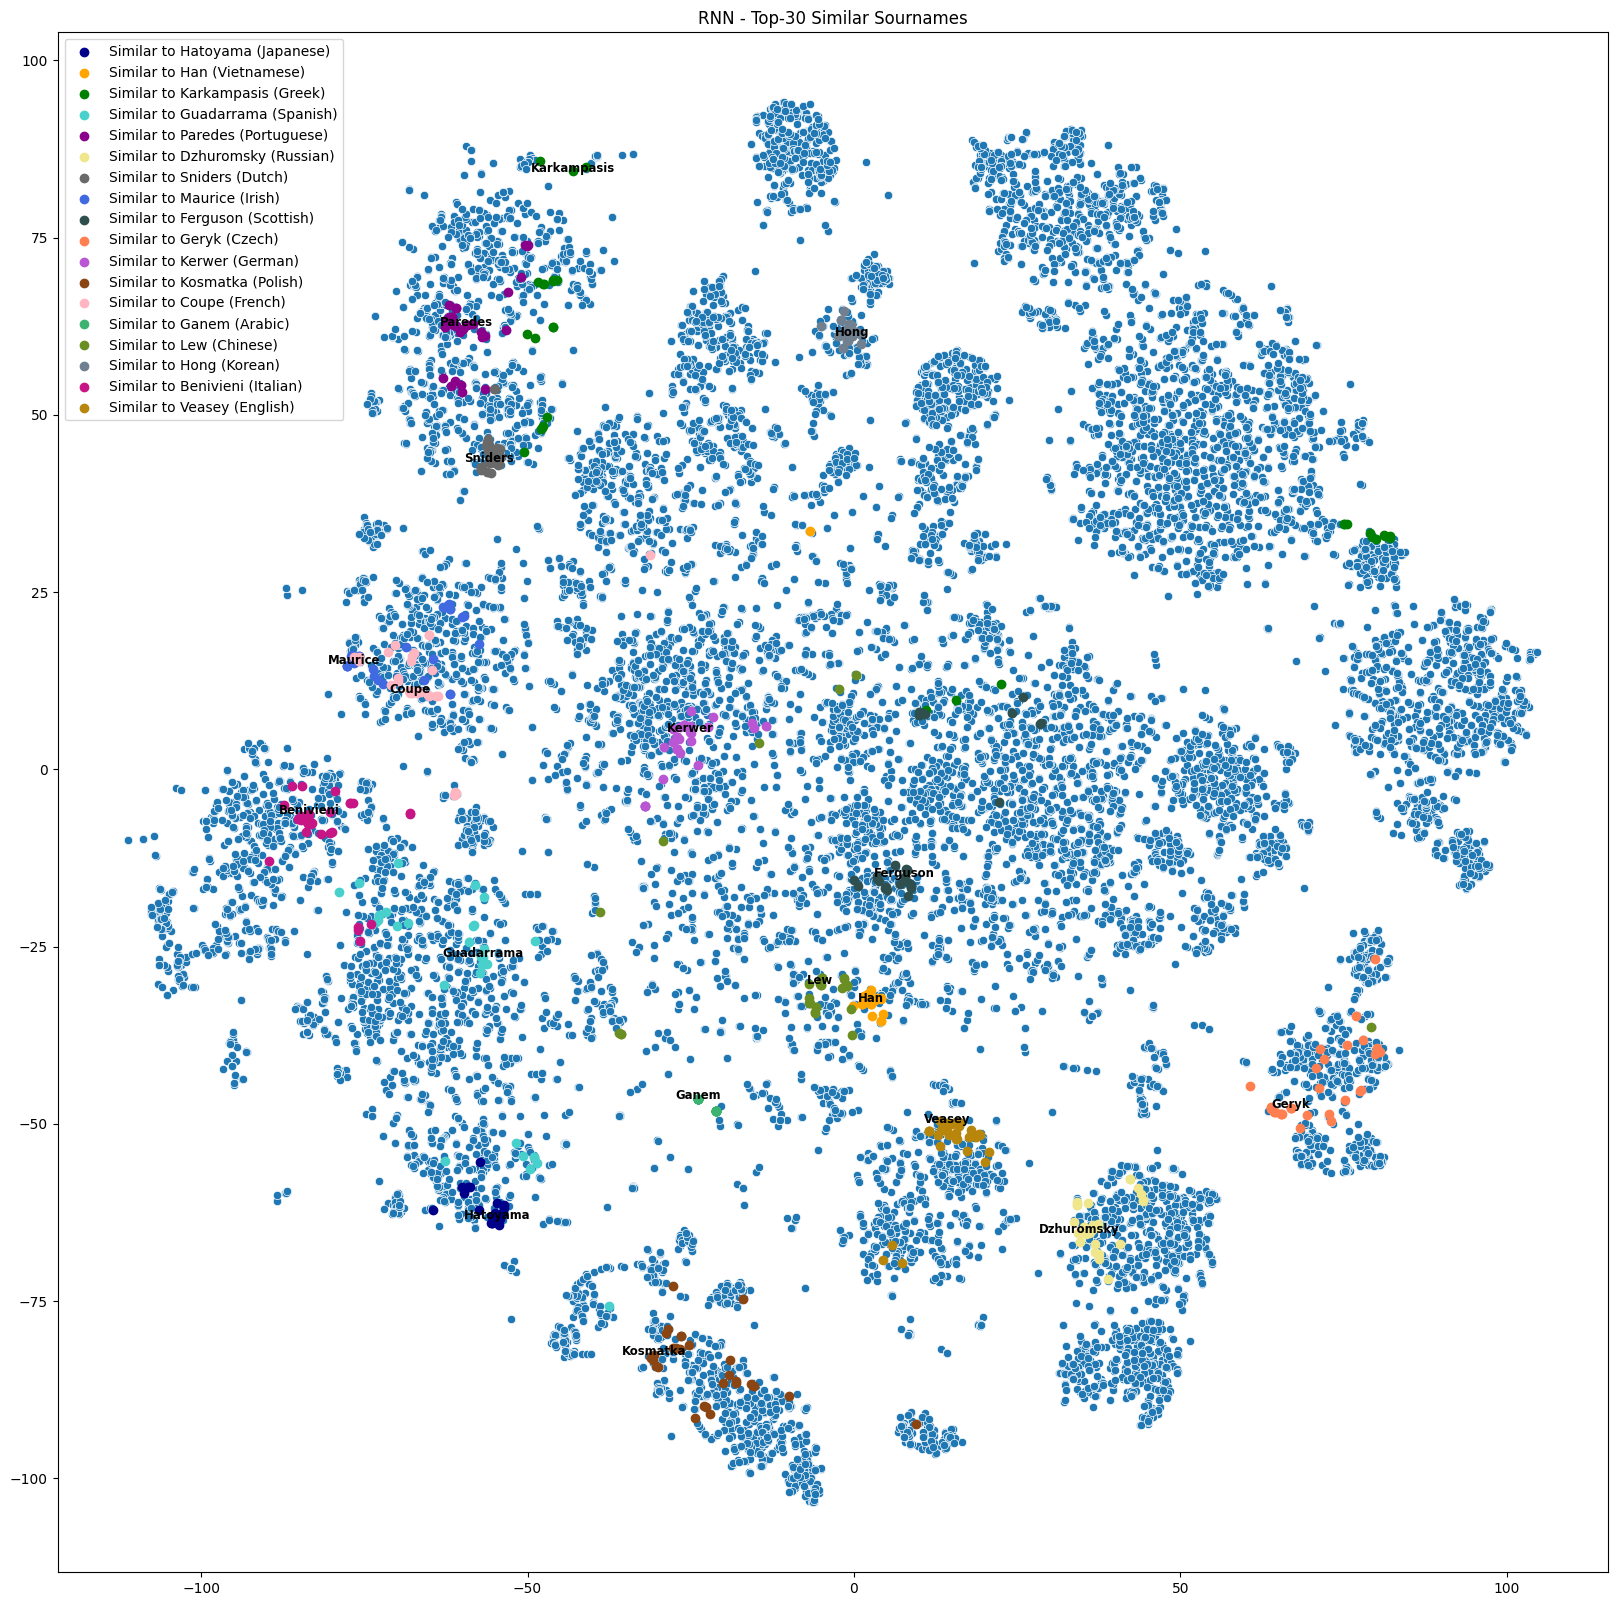

In [61]:
plot_point_features(embeds_tsne_all_rnn, dict_sim_rnn, f'RNN - Top-{top_k} Similar Sournames')

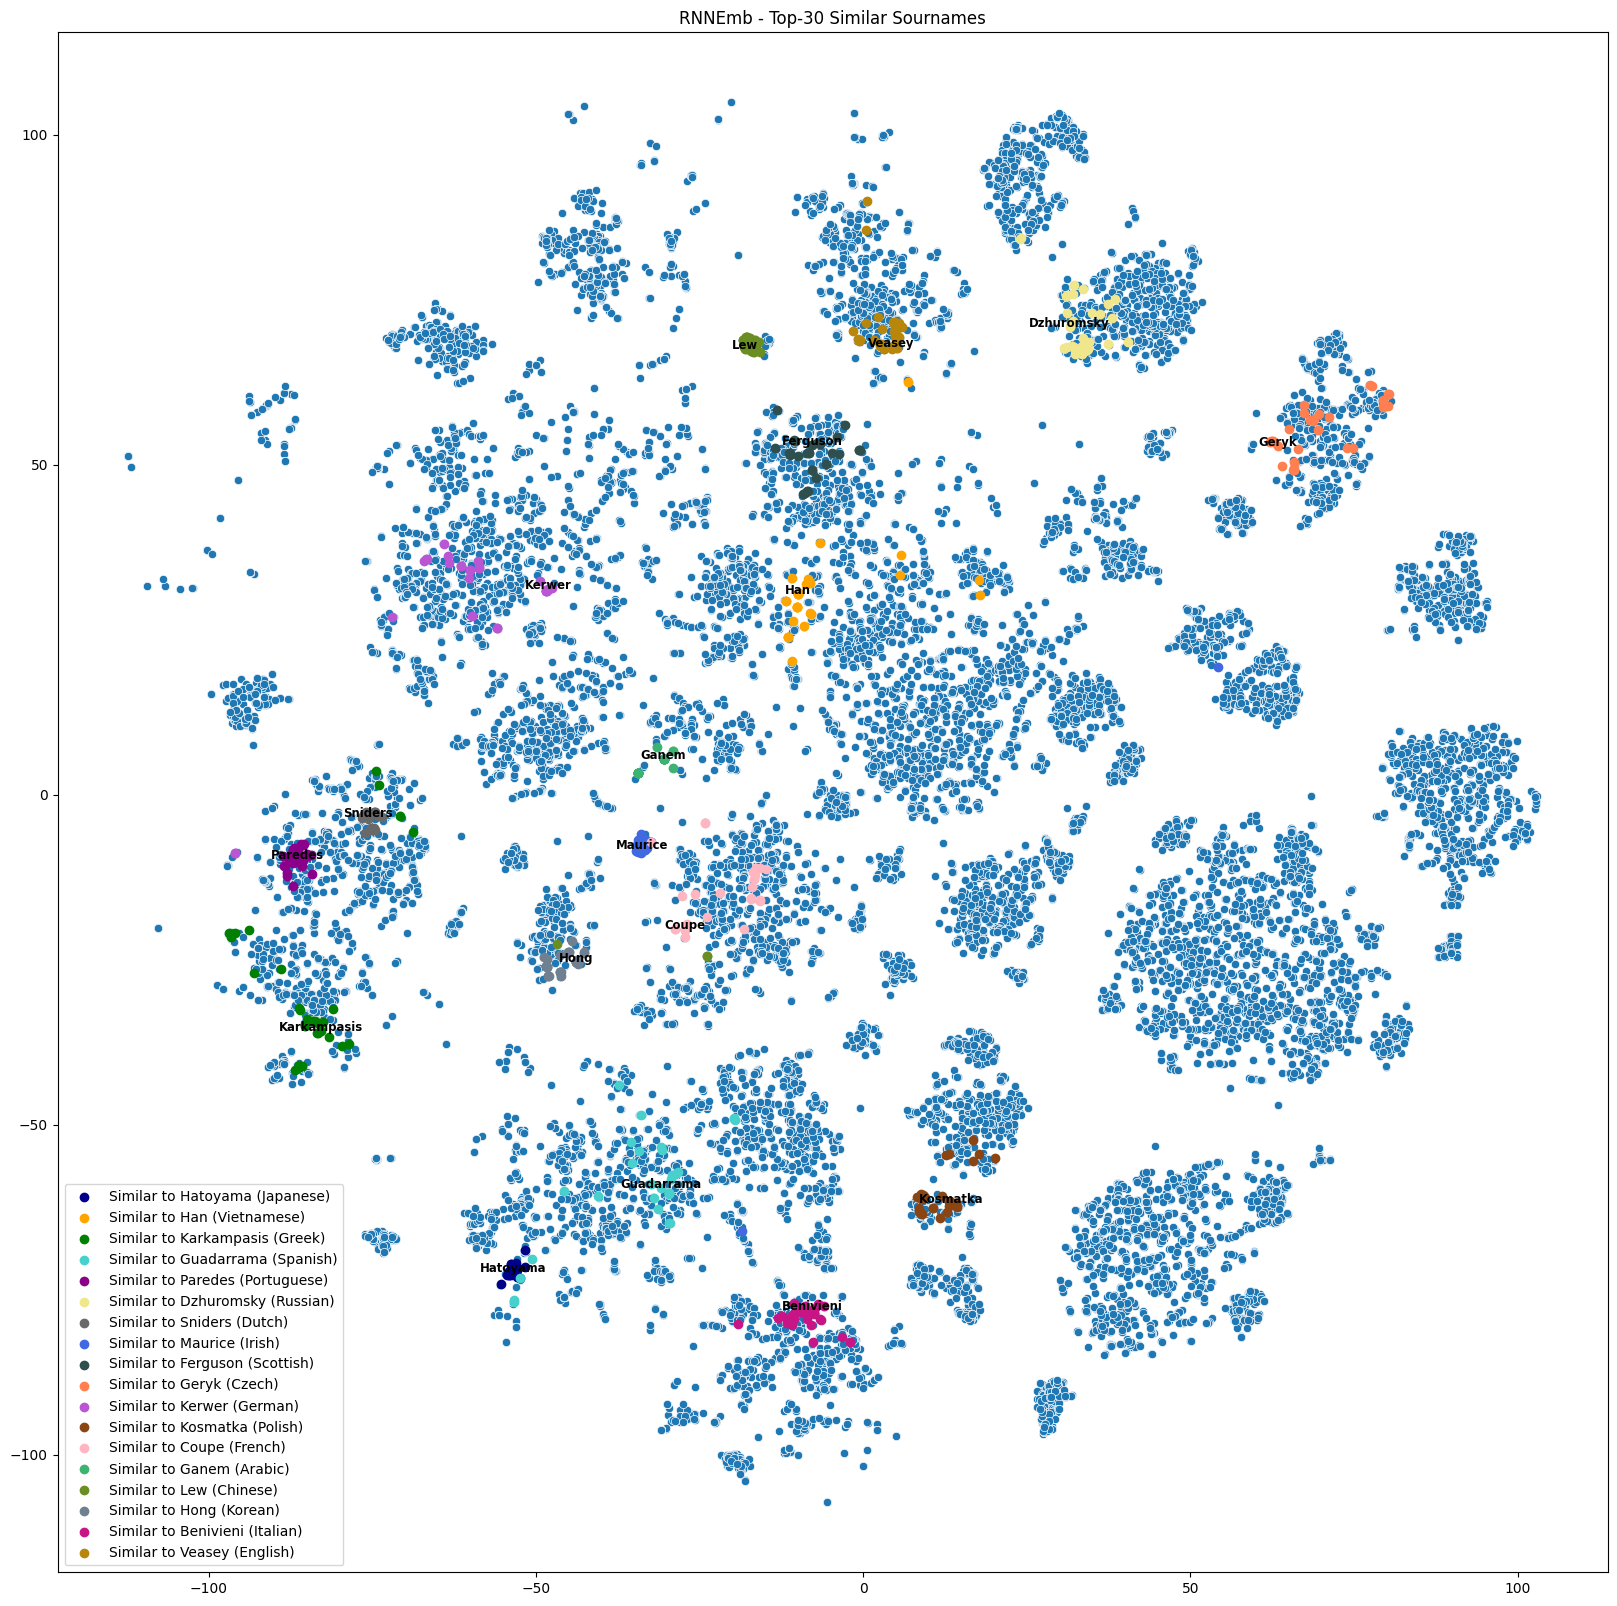

In [62]:
plot_point_features(embeds_tsne_all_rnn_emb, dict_sim_rnn_emb, f'RNNEmb - Top-{top_k} Similar Sournames')

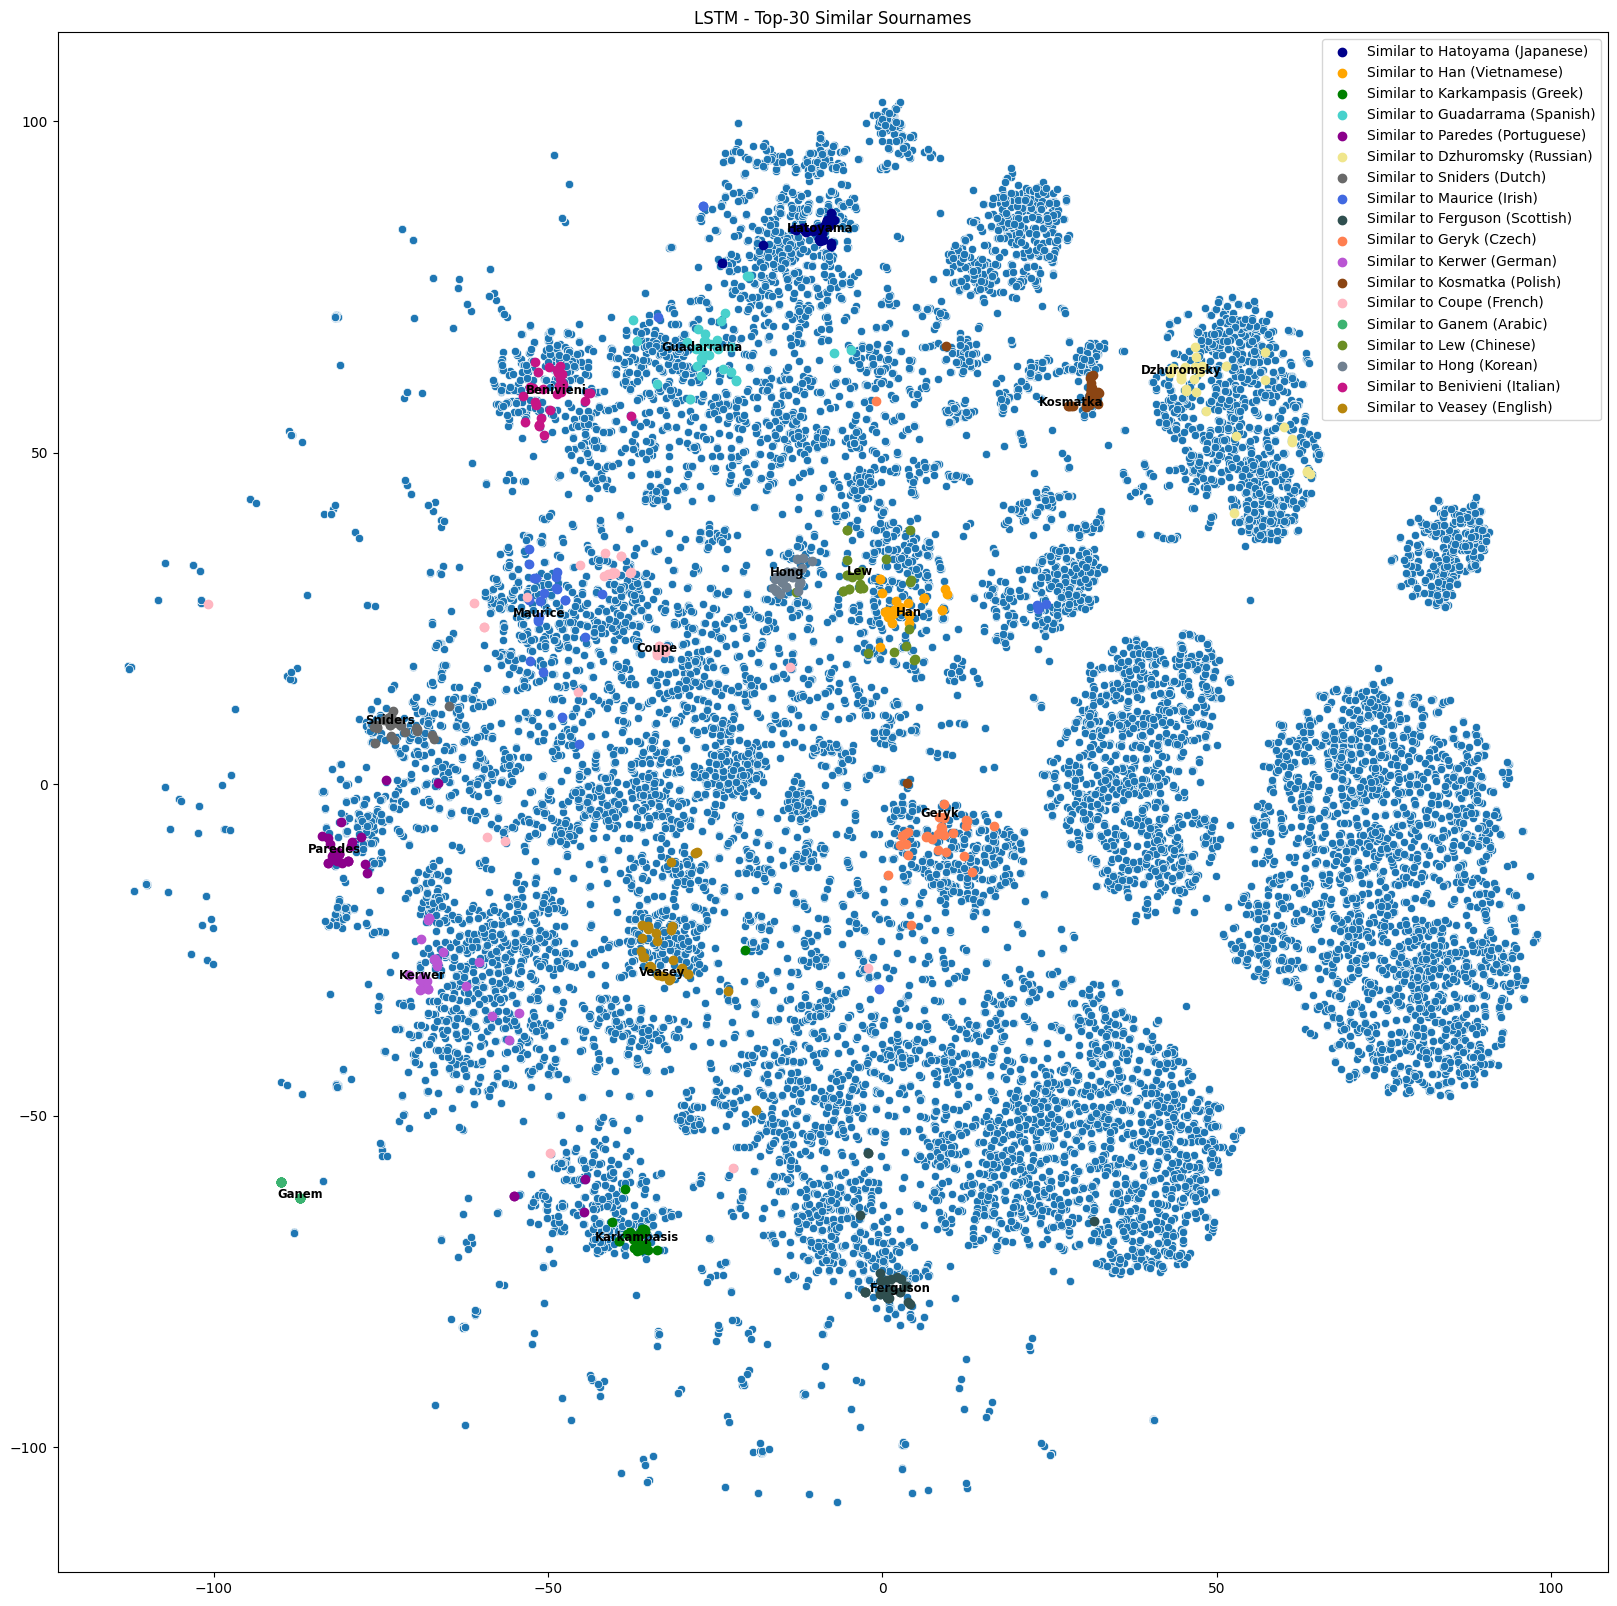

In [63]:
plot_point_features(embeds_tsne_all_lstm, dict_sim_lstm, f'LSTM - Top-{top_k} Similar Sournames')